This notebook creates a network of FS neurons and runs the simulation with and without gap junctions.

First we define a cubic millimeter volume for the FS neurons.

In [1]:
import os
os.environ["SNUDDA_DATA"] = "../../../../BasalGangliaData/data/"
assert os.path.isdir(os.getenv("SNUDDA_DATA")), f"You need to have BasalGangliaData installed for this example. You can run this example without it, but then do not execute this cell."

network_path = os.path.join("FS_network_1")

In [ ]:
from snudda.place import create_cube_mesh

mesh_file = os.path.join(network_path, "mesh", "volume.obj")
create_cube_mesh(mesh_file, [0,0,0], 1e-3, "FS network volume")

Create config file defining the network. Here 1050 FS neurons are added.

In [ ]:
from snudda import SnuddaInit

si = SnuddaInit(network_path=network_path, random_seed=123)

si.define_structure(struct_name="StriatalVolume", struct_mesh=mesh_file, d_min=15e-6, mesh_bin_width=50e-6)

# Should be 1050 neurons, temp reducing it to 50 neurons for runtime of simulation while developing -- OBS increase to 1050!
si.add_neurons(name="FS", num_neurons=50, volume_id="StriatalVolume",
               neuron_dir=os.path.join("$DATA","neurons","striatum","fs"))

cluster_FS_synapses = True
FS_gGABA = [1.1e-9, 1.5e-9]
FS_gGapJunction = [0.5e-9, 0.1e-9]

si.add_neuron_target(neuron_name="FS",
                     target_name="FS",
                     connection_type="GABA",
                     dist_pruning=None,
                     f1=0.15, soft_max=5, mu2=2, a3=1,
                     conductance=FS_gGABA,
                     cluster_synapses=cluster_FS_synapses,
                     mod_file="tmGabaA",
                     channel_param_dictionary={"tau1": (1.33e-3, 1e3),
                                               "tau2": (5.7e-3, 1e3)})
    
si.add_neuron_target(neuron_name="FS",
                     target_name="FS",
                     connection_type="GapJunction",
                     dist_pruning=None,
                     f1=0.7, soft_max=8, mu2=2, a3=1.0,
                     conductance=FS_gGapJunction,
                     cluster_synapses=False,
                     channel_param_dictionary=None)

si.write_json()

In [ ]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, verbose=False)
sp.place()

In [ ]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path)
sd.detect()

In [ ]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path)
sd.detect()

In [ ]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path)
sp.prune()

In [ ]:
import os
from snudda.input import SnuddaInput
si = SnuddaInput(network_path=network_path, 
                 input_config_file="example-FS-input.json",
                 verbose=False)
si.generate()

In [ ]:
!nrnivmodl $SNUDDA_DATA/neurons/mechanisms

In [ ]:
!mpiexec -n 2 snudda simulate FS_network_1 --time 1

Loading FS_network_1/simulation/output.hdf5


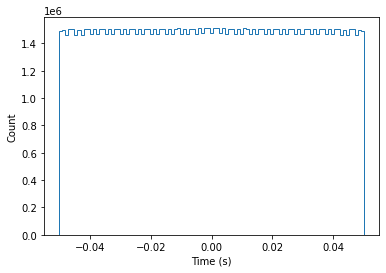

<Figure size 432x288 with 0 Axes>

In [3]:
from snudda.plotting.plot_cross_correlogram import PlotCrossCorrelogram
pcc = PlotCrossCorrelogram(os.path.join(network_path, "simulation", "output.hdf5"))
pcc.plot_all_pair_cross_correlogram(neuron_id=None, fig_file_name=os.path.join(network_path, "figures", "FS-cross-corr.png"))

In [ ]:
ADD SHUFFLE CORRECTION